In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

import torch
import torch.nn as nn

import random
from tqdm import tqdm
import optuna

import pmdarima as pm

import datetime


In [2]:
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")

In [3]:
df = pd.read_csv("../../preprocessed_data/[AI]아파트_층별_소비전력_1시간_2023-03-16 06.00.00 ~ 2023-08-30 10.00.00.csv", usecols=[1,2,3,4])

df

,TIMESTAMP,BUILDING,FLOOR,CONSUMPTION(kW)
0,2023-03-16 06:00:00,561,1,1.174
1,2023-03-16 07:00:00,561,1,1.272
2,2023-03-16 08:00:00,561,1,1.864
3,2023-03-16 09:00:00,561,1,2.381
4,2023-03-16 10:00:00,561,1,2.658
...,...,...,...,...
48151,2023-08-30 06:00:00,563,4,1.499
48152,2023-08-30 07:00:00,563,4,2.088
48153,2023-08-30 08:00:00,563,4,1.940
48154,2023-08-30 09:00:00,563,4,2.326


In [8]:
df_561_1 = df.query("`BUILDING` == 561 and `FLOOR` == 1")
df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
df_561_1.set_index(df_561_1['TIMESTAMP'], drop=True, inplace=True)
df_561_1.drop(['TIMESTAMP', 'BUILDING', 'FLOOR'], axis = 1, inplace=True)
df_561_1

C:\Users\hansung\AppData\Local\Temp\ipykernel_13260\770779451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_13260\770779451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1.drop(['TIMESTAMP', 'BUILDING', 'FLOOR'], axis = 1, inplace=True)


,CONSUMPTION(kW)
TIMESTAMP,
2023-03-16 06:00:00,1.174
2023-03-16 07:00:00,1.272
2023-03-16 08:00:00,1.864
2023-03-16 09:00:00,2.381
2023-03-16 10:00:00,2.658
...,...
2023-08-30 06:00:00,2.050
2023-08-30 07:00:00,1.658
2023-08-30 08:00:00,1.587


In [9]:
# scaled_df = scaled_df.loc["2023-07-18 00:00:00" : '2023-08-31 23:59:00']
df = df_561_1
train_df = df.iloc[:int(len(df) * 0.9)]

test_df = df[int(len(df) * 0.9):]

In [10]:
ow = 24
iw = ow * 2

train = train_df[:-ow]
train = train.to_numpy()

valid = train_df[-ow:]
valid = valid.to_numpy()

In [11]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].reshape([-1,])

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].reshape([-1,])

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [20]:
train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=3)
train_loader = DataLoader(train_dataset, batch_size=64)

In [21]:
train_dataset.len

1172

In [18]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [19]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states) 
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [22]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size).to(device)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size).to(device)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        
        outputs = torch.zeros(batch_size, target_len, input_size).to(device)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :].to(device)
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :].to(device)
            else:
                decoder_input = out.to(device)
            outputs[:,t,:] = out

        return outputs
	
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [23]:
import gc

def objective(trial: optuna.Trial, X, Y, train_loader):
    param = {
        'lr' : trial.suggest_categorical('lr', [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        'epoch' : trial.suggest_int('epoch', 1000, 7000, 1000),
        'hidden_size' : trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256, 512])
    }

    print(param)

    model = lstm_encoder_decoder(input_size=1, hidden_size=param['hidden_size']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = param['lr'])
    criterion = nn.MSELoss()

    model.train()
    with tqdm(range(param['epoch'])) as tr:
        for i in tr:
            total_loss = 0.0
            for x,y in train_loader:
                optimizer.zero_grad()
                x = x.to(device).float()
                y = y.to(device).float()
                output = model(x, y, ow, 0.6)
                loss = criterion(output.to(device), y)
                loss.backward()
                optimizer.step()
                total_loss += loss.cpu().item()
            tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

    prediction = model.predict(torch.tensor(X[-iw:]).reshape(-1,1).to(device).float(), target_len=ow)

    score = mean_absolute_percentage_error(prediction, Y)
    print(score)

    gc.collect()

    return score

In [27]:
from optuna.samplers import TPESampler

# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(lambda trial : objective(trial, train, valid, train_loader), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-21 14:16:15,657] A new study created in memory with name: no-name-48cb9d75-f97d-47f2-9d5e-cb8a0b5aa4c1


{'lr': 0.1, 'epoch': 2000, 'hidden_size': 16}


100%|██████████| 2000/2000 [11:29<00:00,  2.90it/s, loss=0.30925]
[I 2023-11-21 14:27:44,931] Trial 0 finished with value: 0.32035398751499516 and parameters: {'lr': 0.1, 'epoch': 2000, 'hidden_size': 16}. Best is trial 0 with value: 0.32035398751499516.


0.32035398751499516
{'lr': 1e-07, 'epoch': 7000, 'hidden_size': 512}


100%|██████████| 7000/7000 [6:34:09<00:00,  3.38s/it, loss=0.34849]  
[I 2023-11-21 21:01:54,923] Trial 1 finished with value: 0.19270162926707465 and parameters: {'lr': 1e-07, 'epoch': 7000, 'hidden_size': 512}. Best is trial 1 with value: 0.19270162926707465.


0.19270162926707465
{'lr': 0.001, 'epoch': 4000, 'hidden_size': 64}


100%|██████████| 4000/4000 [25:21<00:00,  2.63it/s, loss=0.03935]
[I 2023-11-21 21:27:16,157] Trial 2 finished with value: 0.17747745325002015 and parameters: {'lr': 0.001, 'epoch': 4000, 'hidden_size': 64}. Best is trial 2 with value: 0.17747745325002015.


0.17747745325002015
{'lr': 1e-07, 'epoch': 1000, 'hidden_size': 16}


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s, loss=5.35488]
[I 2023-11-21 21:32:07,189] Trial 3 finished with value: 21.21111857010927 and parameters: {'lr': 1e-07, 'epoch': 1000, 'hidden_size': 16}. Best is trial 2 with value: 0.17747745325002015.


21.21111857010927
{'lr': 1e-06, 'epoch': 1000, 'hidden_size': 64}


100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s, loss=1.77561]
[I 2023-11-21 21:38:27,215] Trial 4 finished with value: 2.5461835923176532 and parameters: {'lr': 1e-06, 'epoch': 1000, 'hidden_size': 64}. Best is trial 2 with value: 0.17747745325002015.


2.5461835923176532
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 64}


100%|██████████| 7000/7000 [44:17<00:00,  2.63it/s, loss=0.32001]
[I 2023-11-21 22:22:44,670] Trial 5 finished with value: 0.19986390849247748 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 64}. Best is trial 2 with value: 0.17747745325002015.


0.19986390849247748
{'lr': 0.01, 'epoch': 5000, 'hidden_size': 128}


100%|██████████| 5000/5000 [1:29:37<00:00,  1.08s/it, loss=219.84005]
[I 2023-11-21 23:52:22,174] Trial 6 finished with value: 1.564954750141834 and parameters: {'lr': 0.01, 'epoch': 5000, 'hidden_size': 128}. Best is trial 2 with value: 0.17747745325002015.


1.564954750141834
{'lr': 0.01, 'epoch': 4000, 'hidden_size': 64}


100%|██████████| 4000/4000 [25:52<00:00,  2.58it/s, loss=0.08928]
[I 2023-11-22 00:18:14,756] Trial 7 finished with value: 0.21356512126919158 and parameters: {'lr': 0.01, 'epoch': 4000, 'hidden_size': 64}. Best is trial 2 with value: 0.17747745325002015.


0.21356512126919158
{'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}


100%|██████████| 6000/6000 [5:37:21<00:00,  3.37s/it, loss=0.07258]  
[I 2023-11-22 05:55:36,324] Trial 8 finished with value: 0.12694092423104866 and parameters: {'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}. Best is trial 8 with value: 0.12694092423104866.


0.12694092423104866
{'lr': 0.0001, 'epoch': 5000, 'hidden_size': 256}


100%|██████████| 5000/5000 [1:27:59<00:00,  1.06s/it, loss=0.00077]
[I 2023-11-22 07:23:35,838] Trial 9 finished with value: 0.14782227074250767 and parameters: {'lr': 0.0001, 'epoch': 5000, 'hidden_size': 256}. Best is trial 8 with value: 0.12694092423104866.


0.14782227074250767
{'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}


100%|██████████| 6000/6000 [5:38:25<00:00,  3.38s/it, loss=0.07473]  
[I 2023-11-22 13:02:01,603] Trial 10 finished with value: 0.10852049948048732 and parameters: {'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.10852049948048732
{'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}


100%|██████████| 6000/6000 [5:41:24<00:00,  3.41s/it, loss=0.06762]  
[I 2023-11-22 18:43:26,120] Trial 11 finished with value: 0.15006119210060007 and parameters: {'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.15006119210060007
{'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}


100%|██████████| 6000/6000 [5:37:35<00:00,  3.38s/it, loss=0.08256]  
[I 2023-11-23 00:21:01,578] Trial 12 finished with value: 0.17156550595100328 and parameters: {'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.17156550595100328
{'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}


100%|██████████| 6000/6000 [5:38:06<00:00,  3.38s/it, loss=0.07233]  
[I 2023-11-23 05:59:08,098] Trial 13 finished with value: 0.12484033579361171 and parameters: {'lr': 1e-05, 'epoch': 6000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.12484033579361171
{'lr': 1e-05, 'epoch': 3000, 'hidden_size': 32}


100%|██████████| 3000/3000 [15:47<00:00,  3.17it/s, loss=0.23191]
[I 2023-11-23 06:14:55,242] Trial 14 finished with value: 0.18496612531531217 and parameters: {'lr': 1e-05, 'epoch': 3000, 'hidden_size': 32}. Best is trial 10 with value: 0.10852049948048732.


0.18496612531531217
{'lr': 1e-05, 'epoch': 5000, 'hidden_size': 512}


100%|██████████| 5000/5000 [4:40:47<00:00,  3.37s/it, loss=0.11344]  
[I 2023-11-23 10:55:42,706] Trial 15 finished with value: 0.1488243065285002 and parameters: {'lr': 1e-05, 'epoch': 5000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.1488243065285002
{'lr': 0.0001, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [2:04:47<00:00,  1.07s/it, loss=0.00023]  
[I 2023-11-23 13:00:30,312] Trial 16 finished with value: 0.13219159273947584 and parameters: {'lr': 0.0001, 'epoch': 7000, 'hidden_size': 256}. Best is trial 10 with value: 0.10852049948048732.


0.13219159273947584
{'lr': 0.1, 'epoch': 6000, 'hidden_size': 128}


100%|██████████| 6000/6000 [3:20:17<00:00,  2.00s/it, loss=0.67684]  
[I 2023-11-23 16:20:48,138] Trial 17 finished with value: 0.18886755551241108 and parameters: {'lr': 0.1, 'epoch': 6000, 'hidden_size': 128}. Best is trial 10 with value: 0.10852049948048732.


0.18886755551241108
{'lr': 0.001, 'epoch': 4000, 'hidden_size': 32}


100%|██████████| 4000/4000 [21:55<00:00,  3.04it/s, loss=0.09621]
[I 2023-11-23 16:42:44,001] Trial 18 finished with value: 0.13080677047504133 and parameters: {'lr': 0.001, 'epoch': 4000, 'hidden_size': 32}. Best is trial 10 with value: 0.10852049948048732.


0.13080677047504133
{'lr': 1e-05, 'epoch': 5000, 'hidden_size': 512}


100%|██████████| 5000/5000 [4:40:40<00:00,  3.37s/it, loss=0.09616]  
[I 2023-11-23 21:23:25,149] Trial 19 finished with value: 0.15946992581959243 and parameters: {'lr': 1e-05, 'epoch': 5000, 'hidden_size': 512}. Best is trial 10 with value: 0.10852049948048732.


0.15946992581959243
{'lr': 1e-05, 'epoch': 3000, 'hidden_size': 512}


 27%|██▋       | 807/3000 [45:12<2:02:51,  3.36s/it, loss=0.20323]
[W 2023-11-23 22:08:37,947] Trial 20 failed with parameters: {'lr': 1e-05, 'epoch': 3000, 'hidden_size': 512} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_13260\3402694182.py", line 6, in <lambda>
    study.optimize(lambda trial : objective(trial, train, valid, train_loader), n_trials = 50)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_13260\3621953642.py", line 26, in objective
    loss.backward()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_

KeyboardInterrupt: 

In [ ]:
study.best_trial

FrozenTrial(number=33, state=TrialState.COMPLETE, values=[0.16593623638617697], datetime_start=datetime.datetime(2023, 11, 18, 23, 45, 28, 366166), datetime_complete=datetime.datetime(2023, 11, 19, 0, 13, 58, 557509), params={'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': CategoricalDistribution(choices=(1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)), 'epoch': IntDistribution(high=7000, log=False, low=1000, step=1000), 'hidden_size': CategoricalDistribution(choices=(16, 32, 64, 128, 256))}, trial_id=33, value=None)

In [60]:
learning_rate=1e-6
epoch = 6000

model = lstm_encoder_decoder(input_size=1, hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [64]:
model.train()
with tqdm(range(6000)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6)
            loss = criterion(output.to(device), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

       

prediction = model.predict(torch.tensor(train[-iw:]).reshape(-1,1).to(device).float(), target_len=ow)

score = mean_absolute_percentage_error(prediction, valid)
print(score)

100%|██████████| 6000/6000 [1:53:44<00:00,  1.14s/it, loss=0.38758]

0.15161876006090194


In [80]:
train_df[-iw:].to_numpy()

array([[3.965],
       [4.671],
       [4.153],
       [4.636],
       [5.443],
       [4.815],
       [6.075],
       [6.607],
       [5.974],
       [3.88 ],
       [3.566],
       [3.701],
       [3.708],
       [3.339],
       [3.918],
       [3.684],
       [4.421],
       [5.571],
       [5.175],
       [4.735],
       [5.09 ],
       [4.671],
       [4.219],
       [4.097],
       [4.08 ],
       [3.845],
       [4.276],
       [4.488],
       [5.67 ],
       [4.798],
       [5.225],
       [6.46 ],
       [5.54 ],
       [4.966],
       [3.954],
       [3.072],
       [2.69 ],
       [2.458],
       [2.946],
       [3.335],
       [3.34 ],
       [4.24 ],
       [4.854],
       [4.932],
       [3.787],
       [4.851],
       [4.94 ],
       [5.785]])

In [85]:
test_df

,CONSUMPTION(W)
TIMESTAMP,
2023-08-13 17:00:00,5.353
2023-08-13 18:00:00,5.612
2023-08-13 19:00:00,5.793
2023-08-13 20:00:00,5.505
2023-08-13 21:00:00,5.962
...,...
2023-08-30 06:00:00,3.313
2023-08-30 07:00:00,3.157
2023-08-30 08:00:00,3.243


In [118]:
predict = model.predict(torch.tensor(test_df[3*iw:4*iw].to_numpy()).reshape(-1,1).float(), target_len=ow)

# predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
# real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [119]:
predict

array([5.485884 , 5.552669 , 5.5856886, 5.6450458, 5.71515  , 5.762538 ,
       5.745004 , 5.6236014, 5.3986225, 5.12081  , 4.866816 , 4.6971407,
       4.629627 , 4.6439223, 4.7035728, 4.775175 , 4.837462 , 4.8833623,
       4.9179006, 4.953274 , 5.00306  , 5.0776978, 5.1822443, 5.3160357],
      dtype=float32)

0.1219658800433473


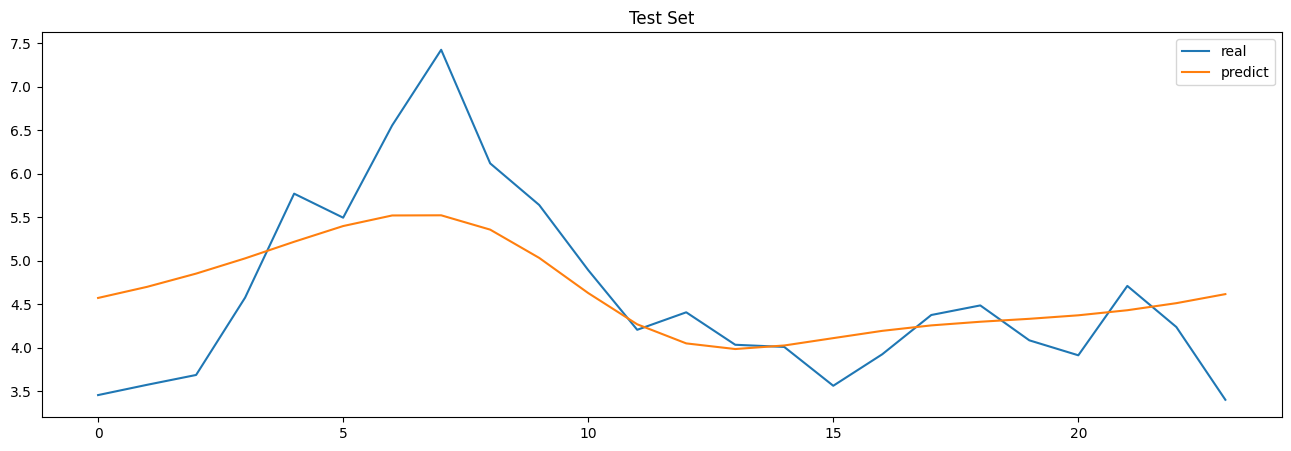

In [121]:
test = test_df[4*ow:5*ow]
print(mean_absolute_percentage_error(test, prediction))

plt.figure(figsize=(16,5))
plt.plot(test.values, label="real")
plt.plot(prediction, label="predict")

plt.title("Test Set")
plt.legend()
plt.show()